In [1]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="5y",interval="1d")

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_ta as ta
from multiprocessing.pool import Pool
from sklearn.manifold import TSNE
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

In [3]:


# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())

# Get the data for this tickers from yahoo finance
# data = yf.download(tickers.Symbol.to_list(),'2021-1-1','2021-7-12', auto_adjust=True)['Close']
# print(data.head())

  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


In [5]:
%%time
with open("hist_data_2018-1-1_2023-7-12.pkl","rb") as f:
    data = pickle.load(f)

CPU times: total: 31.2 ms
Wall time: 23.1 ms


In [6]:
columns = list(data["Open"].columns)

In [7]:
len(columns)

503

In [8]:
coli_with_na = np.where(np.sum(pd.isna(data["Close"]))>0)[0]
for coli in coli_with_na:
    print(columns[coli])

ABNB
BF.B
BRK.B
CARR
CDAY
CEG
CTVA
DOW
FOX
FOXA
GEHC
KVUE
MRNA
OTIS
UBER
VLTO


In [9]:
opens= data["Open"].drop(columns=[columns[coli] for coli in coli_with_na])
closes = data["Close"].drop(columns=[columns[coli] for coli in coli_with_na])
# Open	High	Low	Close	Volume
highs = data["High"].drop(columns=[columns[coli] for coli in coli_with_na])
lows = data["Low"].drop(columns=[columns[coli] for coli in coli_with_na])
volumes = data["Volume"].drop(columns=[columns[coli] for coli in coli_with_na])

In [10]:
opens.shape,closes.shape,highs.shape,lows.shape,volumes.shape

((1389, 487), (1389, 487), (1389, 487), (1389, 487), (1389, 487))

In [12]:
def funcc(x):
    ticker=x
    training_X=[]
    training_Y=[]
    correlation_Y = []
    temp_df_full = pd.DataFrame(data={"Open":opens[ticker],
                             "High":highs[ticker],
                             "Low":lows[ticker],
                             "Close":closes[ticker],
                             "Volume":volumes[ticker],
                            })
    t=0
    while True:
        try:
            temp_df_full.iloc[34+t+1]
        except IndexError :
            break
        temp_df = temp_df_full.iloc[0+t:34+t]
        open0 = temp_df["Open"].iloc[0]
        temp_normed = pd.concat([temp_df["Open"]/open0,
                          temp_df["High"]/open0,
                          temp_df["Low"]/open0,
                          temp_df["Close"]/open0,
                          temp_df["Volume"]/(temp_df["Volume"].iloc[0])*100],axis=1)
        temp_part = pd.concat([temp_df["Open"],
                  temp_df["High"],
                  temp_df["Low"],
                  temp_df["Close"],
                  temp_df["Volume"]],axis=1)
        #temp_df.loc["Open"] = temp_
        temp_df = temp_part.copy()
        ta_df_temp = pd.concat([
#                temp_df.ta.sma()/open0,
#                temp_df.ta.ema()/open0,
#                temp_df.ta.donchian()/open0,
#                temp_df.ta.rsi(),
#                #temp_df.ta.ichimoku()[0],
#                temp_df.ta.fisher(),
#                temp_df.ta.atr()/open0,
#                temp_df.ta.squeeze(),
#                temp_df.ta.bbands()/open0,
#                temp_df.ta.macd(),
#                temp_df.ta.nvi()
               temp_normed.ta.sma(),
               temp_normed.ta.ema(),
               temp_normed.ta.donchian(),
               temp_df.ta.rsi(),
               #temp_df.ta.ichimoku()[0],
               temp_df.ta.fisher(),
               temp_normed.ta.atr(),
               temp_normed.ta.squeeze(),
               temp_normed.ta.bbands(),
               temp_df.ta.macd(),
               temp_df.ta.nvi()
              ],axis=1)
        ans = ta_df_temp.iloc[33].values
        final_df = temp_df_full.iloc[34+t+1]
        result = (final_df["Close"]-final_df["Open"])/(final_df["Close"])
        training_X.append(ans)
        training_Y.append(result)
        correlation_Y.append( temp_df["Open"].iloc[-1] )
        t+=50
    return [training_X,training_Y,correlation_Y]

In [ ]:
# %%time
# dataa = [ ticker for ticker in opens.columns[:]]
# with Pool(16) as pool:
#     res = pool.map(funcc,dataa)

In [ ]:
# training_X = np.vstack([r[0] for r in res])
# training_Y = np.asarray([rr for r in res for rr in r[1]])
# training_Y.shape
# correlation_Y = np.asarray([rr for r in res for rr in r[2]])
# correlation_Y.shape

In [ ]:
# newarr = []
# for col in np.asarray(training_X).T:
#     if np.sum(np.abs(col),axis=0)!=0:
#         newarr.append(col)
# training_X = np.asarray(newarr).T

# training_X = np.asarray( training_X )
# training_Y = np.asarray( training_Y )
# correlation_Y = np.asarray( correlation_Y )

In [13]:
%%time
with open("hist_data_2018-1-1_2023-7-12_trainX_trainY.pkl","rb") as f:
    [training_X,training_Y,correlation_Y] = pickle.load(f)

CPU times: total: 0 ns
Wall time: 2.02 ms


In [14]:
training_X.shape,training_Y.shape,correlation_Y.shape

((13636, 21), (13636,), (13636,))

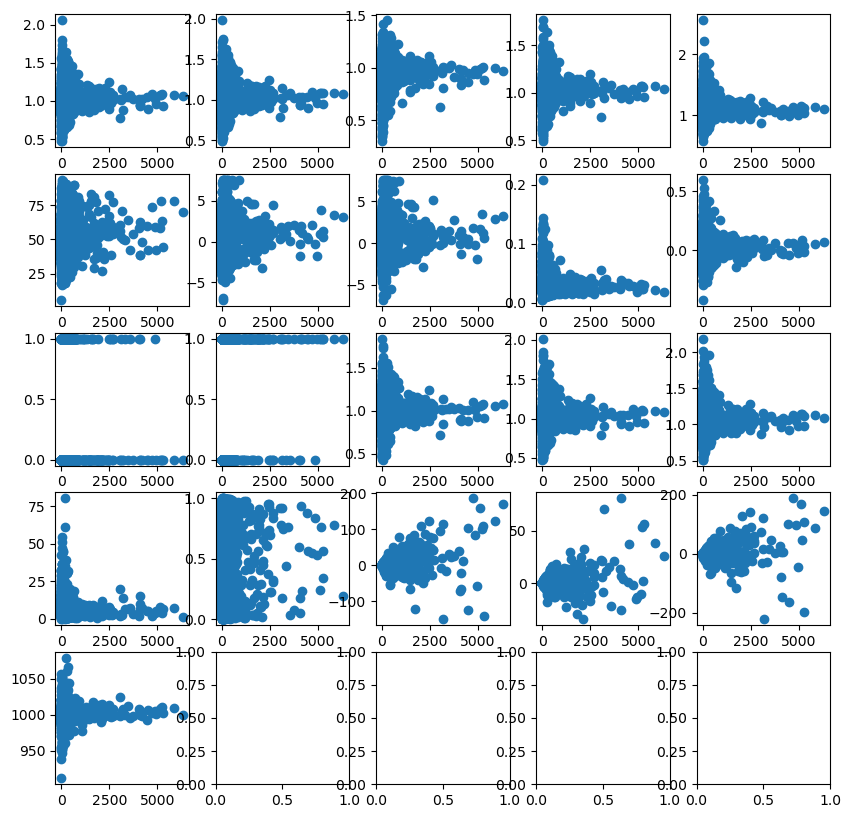

In [15]:
fig,axx=plt.subplots(5,5,figsize=(10,10))
axx=axx.ravel()
for scatter_i, ax in zip( range(len(training_X[0])),axx):
    ax.scatter(  y=training_X[:,scatter_i],x=correlation_Y)

In [18]:
X=np.asarray(training_X)

In [20]:
X[::6].shape

(2273, 21)

5
10
20
50
100
150
CPU times: total: 3min 12s
Wall time: 3min 1s


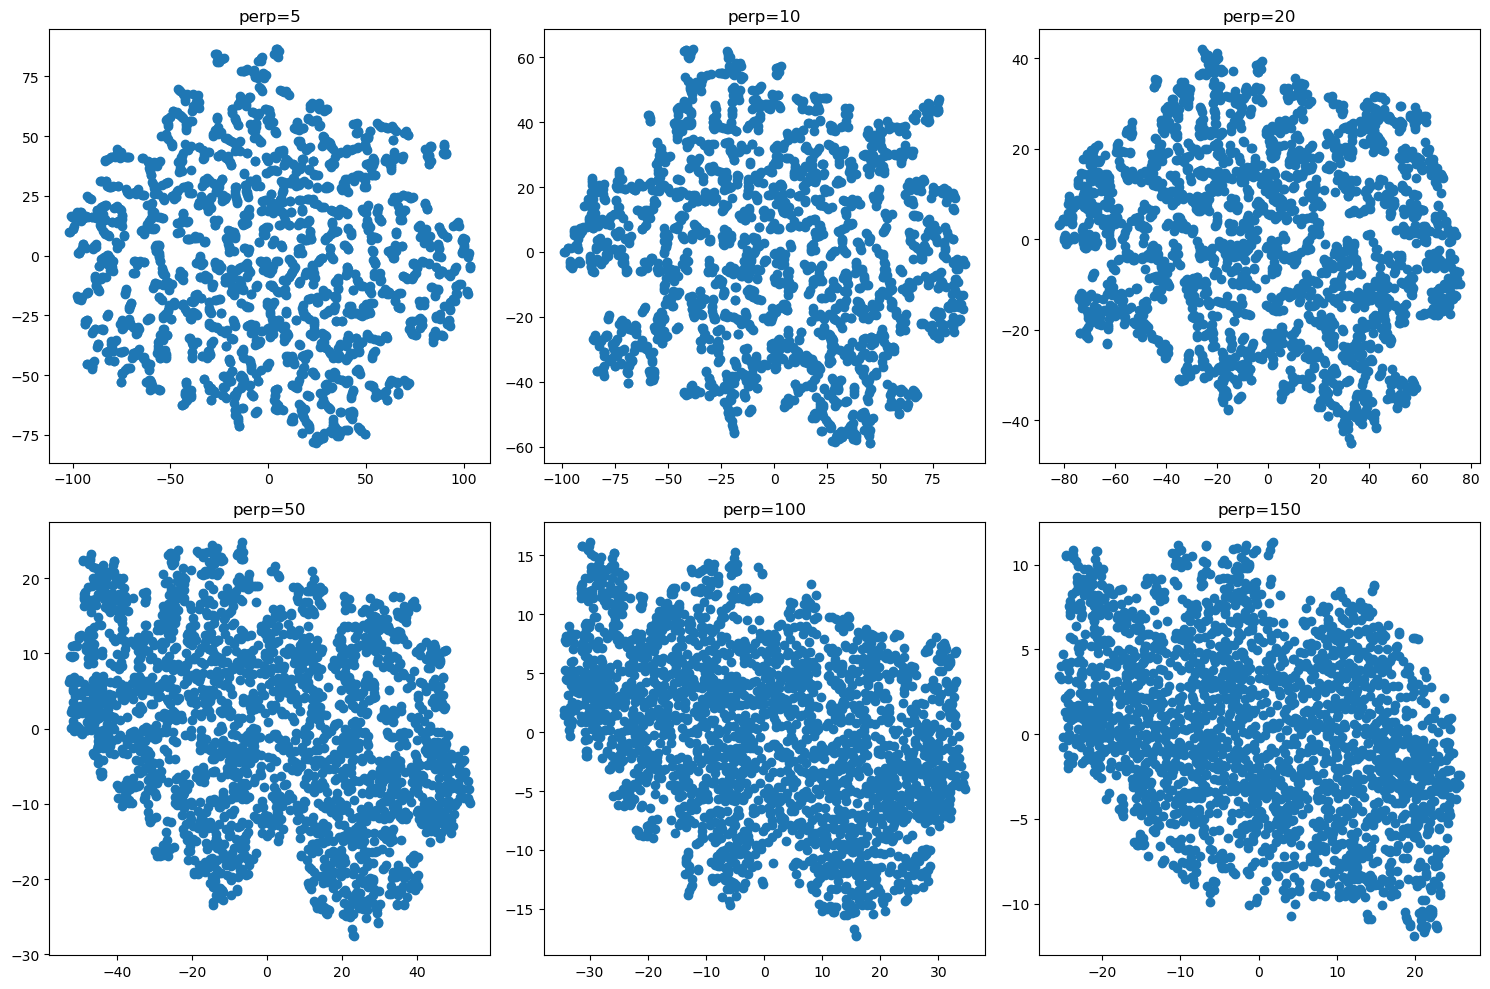

In [21]:
%%time
X=np.asarray(training_X)[::6]

fig,axx=plt.subplots(2,3,figsize=(15,10))
axx=axx.ravel()
for ax,perp in zip(axx,[5,10,20,50,100,150]):
    print(perp)
    X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)
    ax.scatter(X_embedded[:,0],X_embedded[:,1])
    ax.set_title(f"perp={perp}")
plt.tight_layout()

In [23]:
%%time
X=np.asarray(training_X)
X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)

CPU times: total: 15min 7s
Wall time: 7min 55s


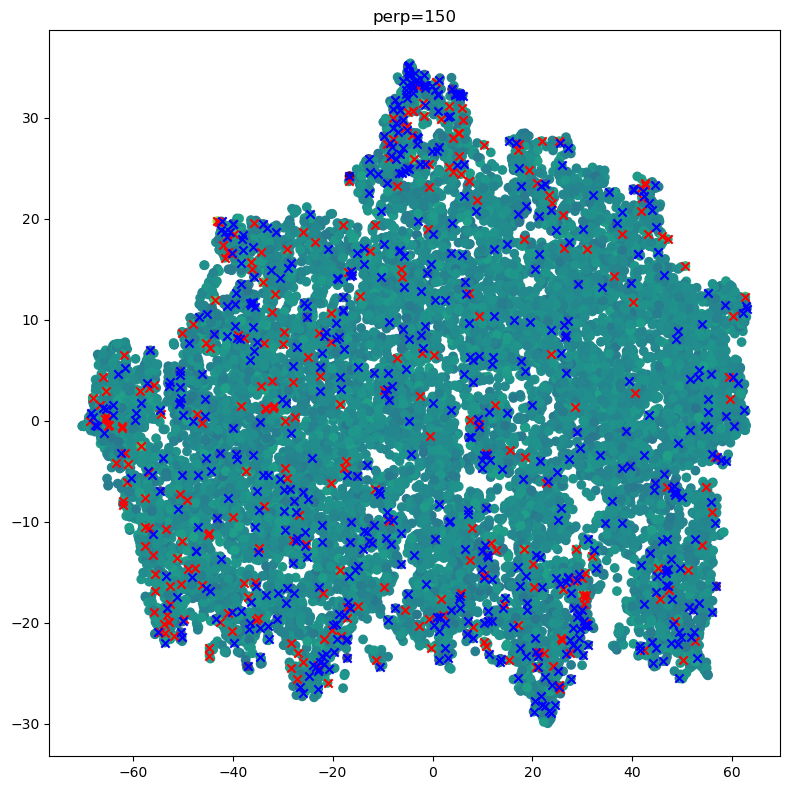

In [24]:
fig,axx=plt.subplots(1,1,figsize=(8,8)) 
ax=axx
#X_embedded = TSNE(n_components=2,init='pca', perplexity=perp).fit_transform(X)
ax.scatter(X_embedded[:,0],X_embedded[:,1],c=np.asarray(training_Y))
selected = np.asarray(training_Y)>0.03

ax.scatter(X_embedded[selected,0],X_embedded[selected,1],c="r",marker="x")


selected = np.asarray(training_Y)<-0.03

ax.scatter(X_embedded[selected,0],X_embedded[selected,1],c="b",marker="x")

ax.set_title(f"perp={perp}")
plt.tight_layout()

In [ ]:
plt.hist(np.asarray(training_Y),bins=100);
plt.axvline(0,c="r")

In [ ]:
train_data_y_discrete = np.asarray(list(map(lambda x: 2 if (x>0.01) else (1 if x<-0.01 else 0),training_Y)))
from collections import Counter
Counter(train_data_y_discrete)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_X, train_data_y_discrete, test_size=0.3,random_state=109)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
%%time
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None)) 
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
%%time
clf = MLPClassifier(random_state=15, max_iter=500,hidden_layer_sizes=[150,150,50,10,50,150]).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred,average=None)) 
print("Recall:",metrics.recall_score(y_test, y_pred,average=None))